#Aprendizaje Automático 2
## TP 2 -Redes Recurrentes
## Problema 1 - Detección de idioma

## Enunciado

En este problema, se presenta un conjunto de datos que contiene clips de audio correspondientes a oraciones habladas en distintos idiomas.


### **Dataset**
https://www.tensorflow.org/datasets/catalog/xtreme_s


El dataset proporcionado incluye diversos sub-datasets correspondientes a oraciones habladas en distintos idiomas. Utilizaremos un subconjunto de estos datasets para entrenar un clasificador de idiomas hablados.


### **Objetivo**
Utilizando el dataset proporcionado, el objetivo es construir un modelo de clasificación utilizando redes neuronales que pueda inferir el idioma correspondiente.


Como paso preliminar, se solicita construir un dataset de clasificación utilizando los siguientes idiomas del set de datos:


*   Español: https://www.tensorflow.org/datasets/catalog/xtreme_s#xtreme_sfleurses_419
*   Inglés: https://www.tensorflow.org/datasets/catalog/xtreme_s#xtreme_sfleursen_us
*   Francés: https://www.tensorflow.org/datasets/catalog/xtreme_s#xtreme_sfleursfr_fr
*   Japonés: https://www.tensorflow.org/datasets/catalog/xtreme_s#xtreme_sfleursja_jp

Se solicita entrenar dos modelos de distintas arquitecturas y comparar los resultados:

* Modelo convolucional sobre los espectrogramas de los clips.
* Modelo recurrente sobre los espectrogramas de los clips.

Ver https://colab.research.google.com/github/FCEIA-AAII/lab11/blob/master/lab11-a.ipynb como ejemplo de obtención de espectrogramas a partir de clips de audio.


### **Entrega**
La entrega debe incluir:

Código fuente de la solución implementada en Google Colab, que incluya:

Análisis previo y preprocesamiento del set de datos.
Definición y entrenamiento del modelo.
Resultados de la evaluación de los modelos, incluyendo métricas de desempeño y visualizaciones relevantes.
Nota: el código debe estar debidamente documentado con comentarios explicativos para que el trabajo sea fácilmente comprensible para otros revisores.

##Setup

Librerías y Dependencias

In [ ]:
import shutil

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
!pip install -U tensorflow_datasets

In [ ]:
!pip install pydub
!apt-get install ffmpeg -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import tensorflow as tf
from tqdm import tqdm  # Importar tqdm para la barra de progreso

In [ ]:
import os

In [ ]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
pip install pydub


Establecer GPU por defecto en caso de estar disponible

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## Carga de Datos

In [ ]:
!gdown --id 1isbsqKD1Al_I-39rqzIi_pGCLb89MEtx -O dataset_reducido.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1isbsqKD1Al_I-39rqzIi_pGCLb89MEtx
From (redirected): https://drive.google.com/uc?id=1isbsqKD1Al_I-39rqzIi_pGCLb89MEtx&confirm=t&uuid=1fbee7ab-2c64-45ce-91a1-ad300c7d1180
To: /content/dataset_reducido.zip
100% 427M/427M [00:09<00:00, 46.2MB/s]


In [ ]:
!unzip dataset_reducido.zip -d ./dataset_reducido

Archive:  dataset_reducido.zip
   creating: ./dataset_reducido/español/
  inflating: ./dataset_reducido/español/1001744349579669536.wav  
  inflating: ./dataset_reducido/español/1007153953391704970.wav  
  inflating: ./dataset_reducido/español/1009772077090409679.wav  
  inflating: ./dataset_reducido/español/1013105803699497262.wav  
  inflating: ./dataset_reducido/español/1014289795206707108.wav  
  inflating: ./dataset_reducido/español/1021561597309617046.wav  
  inflating: ./dataset_reducido/español/1035178855965321126.wav  
  inflating: ./dataset_reducido/español/1038250874850975162.wav  
  inflating: ./dataset_reducido/español/1039053687601070693.wav  
  inflating: ./dataset_reducido/español/1049023338577854181.wav  
  inflating: ./dataset_reducido/español/1054080901105124788.wav  
  inflating: ./dataset_reducido/español/1055331510865031484.wav  
  inflating: ./dataset_reducido/español/106043982422404217.wav  
  inflating: ./dataset_reducido/español/1067516735953621562.wav  
  inf

In [ ]:
import os
from pydub import AudioSegment

def convert_to_mono(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith(".wav"):
                input_path = os.path.join(root, file)
                output_path = os.path.join(output_dir, os.path.relpath(input_path, input_dir))

                # Crear subdirectorios si no existen
                os.makedirs(os.path.dirname(output_path), exist_ok=True)

                # Leer el archivo de audio
                audio = AudioSegment.from_file(input_path)

                # Convertir a mono si no lo está
                if audio.channels != 1:
                    audio = audio.set_channels(1)

                # Exportar en formato PCM
                audio.export(output_path, format="wav", parameters=["-ar", "16000"])
                print(f"Convertido: {input_path} -> {output_path}")

# Directorios de entrada y salida
input_directory = "./dataset_reducido"
output_directory = "./dataset_reducido"

convert_to_mono(input_directory, output_directory)


Convertido: ./dataset_reducido/frances/731098557186982809.wav -> ./dataset_reducido/frances/731098557186982809.wav
Convertido: ./dataset_reducido/frances/871665154829167793.wav -> ./dataset_reducido/frances/871665154829167793.wav
Convertido: ./dataset_reducido/frances/35974902947379053.wav -> ./dataset_reducido/frances/35974902947379053.wav
Convertido: ./dataset_reducido/frances/388079275449675927.wav -> ./dataset_reducido/frances/388079275449675927.wav
Convertido: ./dataset_reducido/frances/570848824226786121.wav -> ./dataset_reducido/frances/570848824226786121.wav
Convertido: ./dataset_reducido/frances/1058050494562584250.wav -> ./dataset_reducido/frances/1058050494562584250.wav
Convertido: ./dataset_reducido/frances/93914404268217550.wav -> ./dataset_reducido/frances/93914404268217550.wav
Convertido: ./dataset_reducido/frances/703260354733243292.wav -> ./dataset_reducido/frances/703260354733243292.wav
Convertido: ./dataset_reducido/frances/614831238897894481.wav -> ./dataset_reducid

In [ ]:
# Ruta al directorio donde está el dataset descomprimido
data_dir = "./dataset_reducido"

# Cargar el dataset desde el directorio
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,  # Tamaño de lote
    validation_split=0.2,  # Porcentaje de validación
    seed=0,  # Semilla para dividir consistentemente
    output_sequence_length=80000,  # Duración fija de 5 segundos (a 16kHz)
    subset="both"  # Entrenamiento y validación
)

# Ver etiquetas únicas
label_names = np.array(train_ds.class_names)
print("Label names:", label_names)

Found 800 files belonging to 4 classes.
Using 640 files for training.
Using 160 files for validation.
Label names: ['español' 'frances' 'ingles' 'japones']


In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 80000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

El dataset contiene un solo canal de audio por clip, usamos `tf.squeeze` para descartar el eje extra.

In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 80000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)


(64, 80000)
(64,)


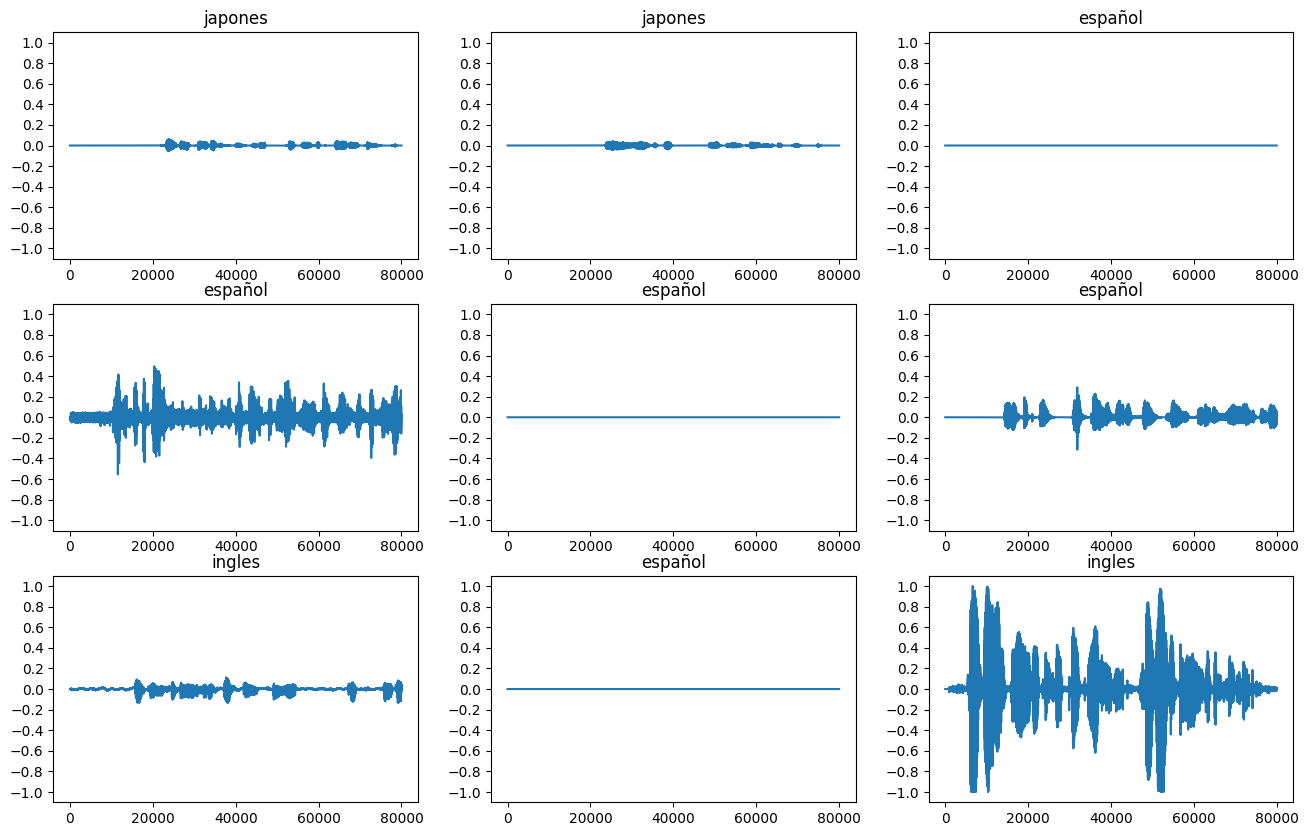

In [ ]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])


### Conversión de formas de onda a espectrogramas


In [ ]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: japones
Waveform shape: (80000,)
Spectrogram shape: (624, 129, 1)
Audio playback


Label: japones
Waveform shape: (80000,)
Spectrogram shape: (624, 129, 1)
Audio playback


Label: español
Waveform shape: (80000,)
Spectrogram shape: (624, 129, 1)
Audio playback


Definimos una función para mostrar el espectrograma:

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Ploteamos formas de onda y sus respectivos espectrogramas.

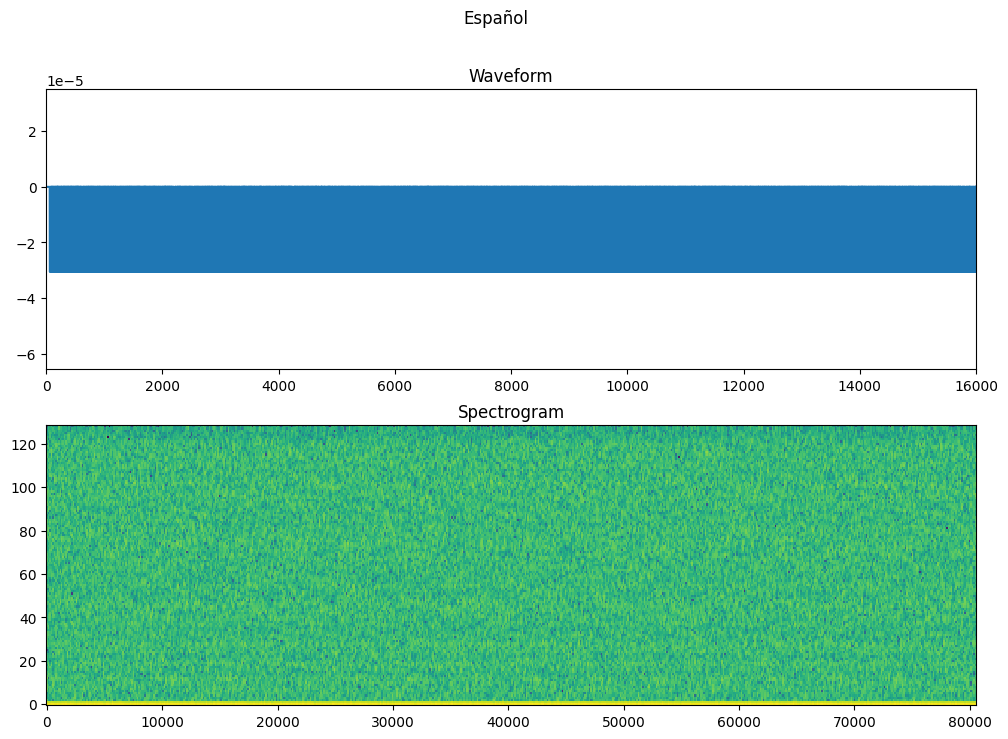

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Ahora creamos un dataset de espectrogramas utilizando la función definida.

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

Examinar el espectrograma para distintos ejemplos del dataset.

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

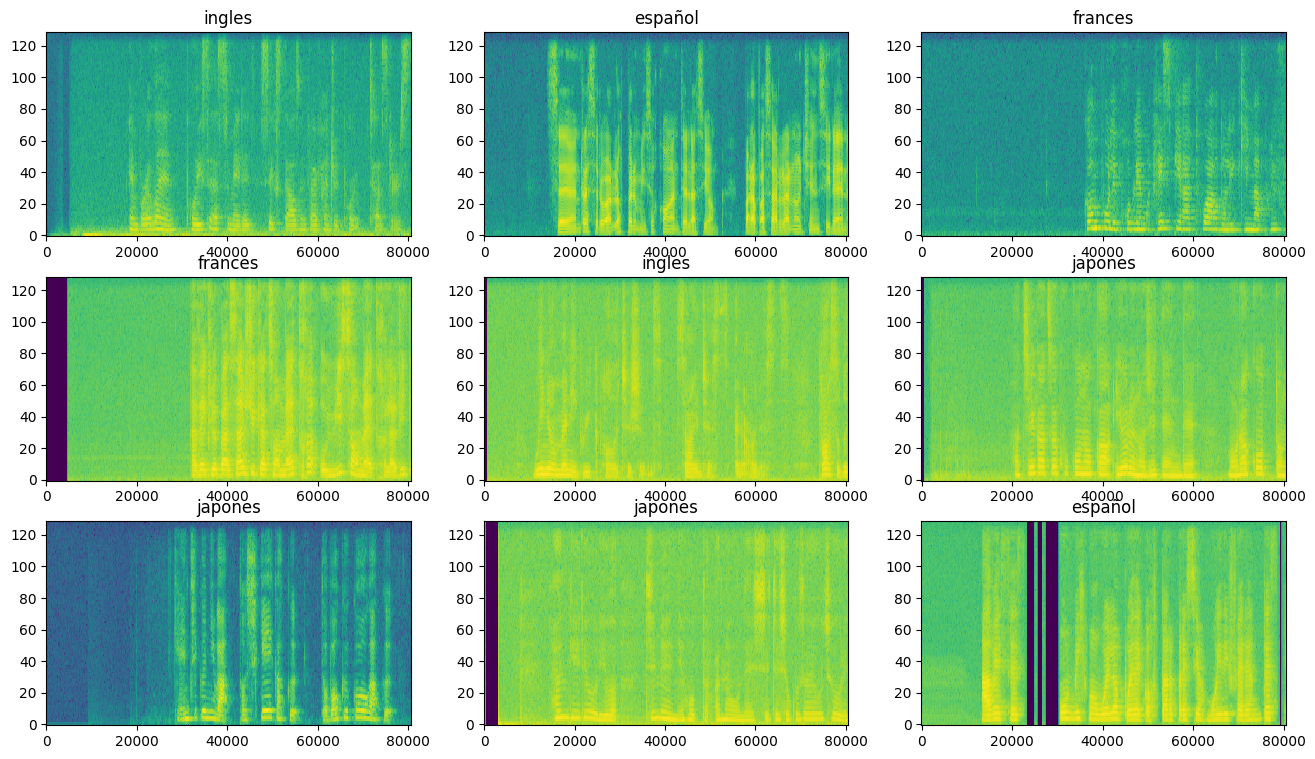

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Construir y Entrenar el Modelo

Optimizamos la carga del dataset

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

##Clasificacion de audio con CNN

Para el modelo, se utilizará una red neuronal convolucional simple (CNN), ya que se han transformado los archivos de audio en imágenes de espectrograma.

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (624, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 124, 124, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 124, 124, 1)         │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 122, 122, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 120, 120, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 60, 60, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 60, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 230400)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      29,491,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,510,663 (112.57 MB)

 Trainable params: 29,510,660 (112.57 MB)

 Non-trainable params: 3 (16.00 B)

Compilamos el modelo:

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Entrenamos 50 epochs con early stopping:

In [ ]:
EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - accuracy: 0.2732 - loss: 2.6664 - val_accuracy: 0.5188 - val_loss: 1.2577
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.5304 - loss: 1.2477 - val_accuracy: 0.5125 - val_loss: 1.2887
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - accuracy: 0.5271 - loss: 1.2059 - val_accuracy: 0.5000 - val_loss: 1.1185
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - accuracy: 0.6383 - loss: 0.9545 - val_accuracy: 0.5063 - val_loss: 0.9710
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - accuracy: 0.6445 - loss: 0.8375 - val_accuracy: 0.6062 - val_loss: 0.9147
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.7002 - loss: 0.7272 - val_accuracy: 0.6250 - val_loss: 0.8700
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.7554 - loss: 0.6363 - val_accuracy: 0.6062 - val_loss: 0.8543
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - accuracy: 0.8127 - loss: 0.5200 - val_accuracy: 0.6187 - val_loss:

Ploteamos resultados:

Text(0, 0.5, 'Accuracy [%]')

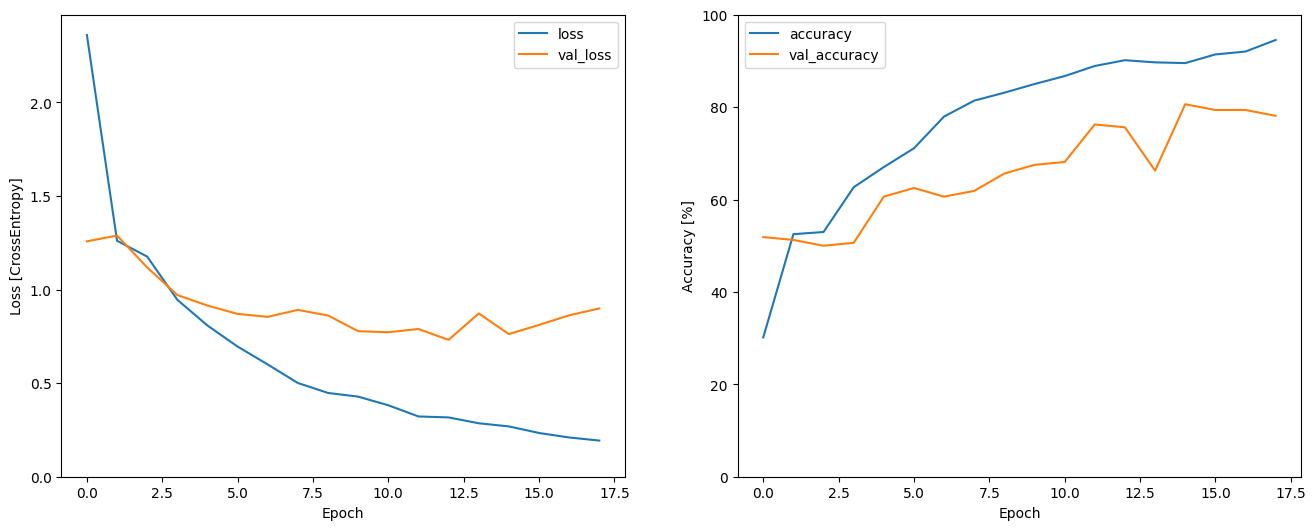

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Mostrar una matriz de confusión

Utilizar una [matriz de confusión](https://developers.google.com/machine-learning/glossary#confusion-matrix) para verificar qué tan bien clasificó el modelo cada uno de los comandos en el conjunto de prueba:

In [ ]:
y_pred = model.predict(val_spectrogram_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 901ms/step


In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

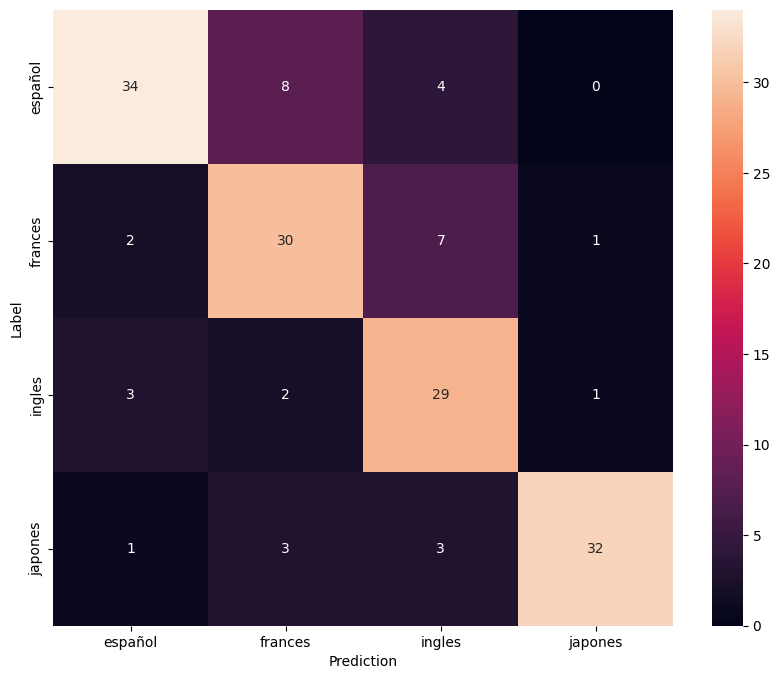

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Inferir sobre un archivo de audio

Finalmente, inferimos sobre un archivo de audio (en este caso tomamos un archivo del dataset arbitrario, podría ser un archivo .wav completamente nuevo).

##RNN

## Actividad: Redes Recurrentes

Adaptar el preprocesamiento y modelo utilizando redes recurrentes. Interpretar al espectrograma como una secuencia de vectores de amplitud frecuencial.

In [ ]:
for spec, label in train_spectrogram_ds.take(1):
    print(f"Forma del espectrograma: {spec.shape}")
    print(f"Forma de Etiqueta: {label.shape}")

Forma del espectrograma: (64, 624, 129, 1)
Forma de Etiqueta: (64,)


In [ ]:
def preprocess_rnn_data(spectrogram, label):
    # Eliminar la dimensión de canal
    spectrogram = tf.squeeze(spectrogram, axis=-1)  # De (batch, 624, 129, 1) a (batch, 624, 129)

    # Reorganizar a formato RNN: (timesteps, features)
    spectrogram = tf.transpose(spectrogram, perm=[0, 2, 1])  # De (batch, 624, 129) a (batch, 129, 624)

    return spectrogram, label

In [ ]:
train_rnn_ds = train_spectrogram_ds.map(preprocess_rnn_data, num_parallel_calls=tf.data.AUTOTUNE)
val_rnn_ds = val_spectrogram_ds.map(preprocess_rnn_data, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras import layers, models

# Definición del modelo
model = models.Sequential([
    layers.Input(shape=(129, 624)),  # Forma: (timesteps, features)

    # Primera capa recurrente
    layers.LSTM(64, return_sequences=True),  # LSTM con 64 unidades, devuelve toda la secuencia

    # Segunda capa recurrente
    layers.LSTM(32),  # LSTM con 32 unidades, devuelve solo la última salida

    # Capa densa
    layers.Dense(64, activation='relu'),  # Capa totalmente conectada con 64 unidades

    # Regularización
    layers.Dropout(0.5),

    # Capa de salida
    layers.Dense(num_labels, activation='softmax')  # `num_labels` = número de clases
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Etiquetas como enteros
              metrics=['accuracy'])

# Resumen del modelo
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 129, 64)             │         176,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 191,172 (746.77 KB)

 Trainable params: 191,172 (746.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_rnn_ds,
    validation_data=val_rnn_ds,
    epochs=30,  # Ajusta el número de épocas según el rendimiento
    batch_size=128
)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 355ms/step - accuracy: 0.2576 - loss: 1.3763 - val_accuracy: 0.3125 - val_loss: 1.3642
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 451ms/step - accuracy: 0.3250 - loss: 1.3264 - val_accuracy: 0.3125 - val_loss: 1.3362
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 312ms/step - accuracy: 0.3581 - loss: 1.2954 - val_accuracy: 0.3375 - val_loss: 1.3252
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - accuracy: 0.4213 - loss: 1.2565 - val_accuracy: 0.3313 - val_loss: 1.2928
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 465ms/step - accuracy: 0.4152 - loss: 1.1748 - val_accuracy: 0.3688 - val_loss: 1.2765
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 318ms/step - accuracy: 0.4492 - loss: 1.1408 - val_accuracy: 0.3375 - val_loss: 1.2984
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.4465 - loss: 1.1029 - val_accuracy: 0.3750 - val_loss: 1.3052
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 433ms/step - accuracy: 0.4963 - loss: 1.0732 - val_accuracy: 0.

In [ ]:
test_loss, test_accuracy = model.evaluate(val_rnn_ds)
print(f"Precisión en validación: {test_accuracy * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.4008 - loss: 2.2459
Precisión en validación: 38.75%


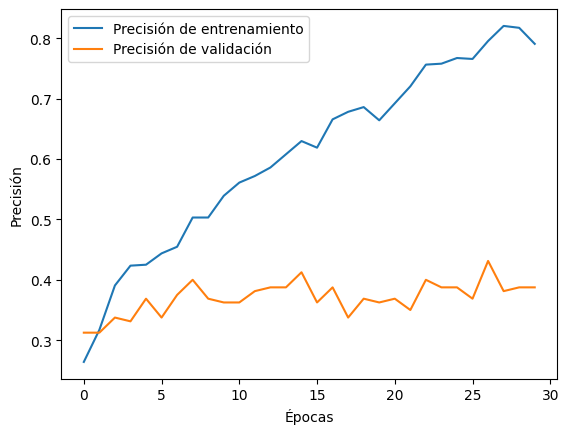

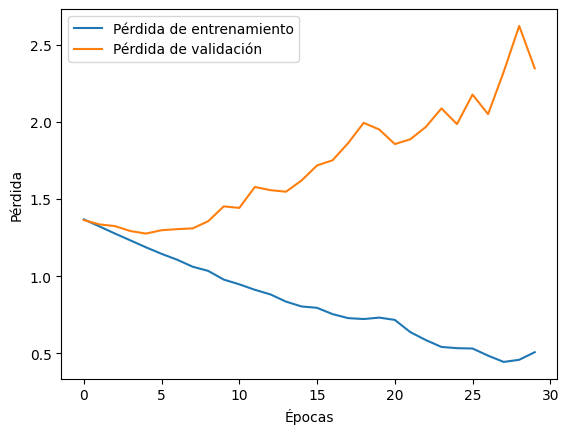

In [ ]:
import matplotlib.pyplot as plt

# Precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
for spec, label in val_rnn_ds.take(1):
    pred = model.predict(spec)
    print(f"Predicción: {tf.argmax(pred, axis=1)}")
    print(f"Etiqueta real: {label.numpy()}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Predicción: [2 3 2 3 1 1 1 1 0 0 2 1 3 0 3 0 2 0 3 1 0 1 2 1 0 1 1 3 3 0 1 0 2 0 0 0 0
 1 3 0 0 2 3 0 3 3 0 2 0 3 2 0 1 1 1 2 0 1 3 3 0 3 2 3]
Etiqueta real: [2 3 2 2 0 1 1 3 1 2 2 3 0 1 1 1 1 0 2 3 1 1 2 3 2 0 1 3 3 1 3 0 0 0 1 0 0
 0 0 0 0 2 2 1 0 2 0 2 0 1 0 0 3 2 1 2 1 1 1 2 3 1 1 3]
